In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary
import os
from torchvision import transforms
import csv
from PIL import Image
import pandas as pd
import numpy as np

# best_model = os.path.normpath("C:/Users/arwin/Documents/dev/APS360-PROJECT/transfer_learning/transfermodel_bs128_lr0.0005_epoch75_wd0/transfermodel_bs128_lr0.0005_epoch75_wd0.pth")
best_model = os.path.normpath("C:/Users/arwin/Documents/dev/APS360-PROJECT/transfer_learning/transfermodel_bs512_lr0.001_epoch100_wd0/transfermodel_bs512_lr0.001_epoch100_wd0.pth")

bb_path = os.path.normpath('C:/Users/arwin/Documents/dev/APS360-PROJECT/data/billboard_spec')
rand_path = os.path.normpath('C:/Users/arwin/Documents/dev/APS360-PROJECT/data/random_spec')  

bb_csv = os.path.normpath('C:/Users/arwin/Documents/dev/APS360-PROJECT/data/billboard_genres_filled.csv')  
rand_csv = os.path.normpath('C:/Users/arwin/Documents/dev/APS360-PROJECT/data/random_songs_sampled_genres_filled.csv')  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Define Transfer Learning Model Class (and modification)

In [2]:

class BigModel(nn.Module):
  def  __init__(self):
    super(BigModel, self).__init__()
    # CNN
    resnet18 = models.resnet18(pretrained=True)
    self.features = nn.Sequential(*(list(resnet18.children())[:-2])) # I removed the last two layers of resnet and replaced them with the ones said in the paper
    self.features.add_module("pool", nn.AdaptiveMaxPool2d((1,1)))

    self.fc1_cnn = nn.Linear(512, 256)
    self.dropout_cnn = nn.Dropout(p = 0.5)
    self.batch_norm_cnn = nn.BatchNorm1d(256)
    
    # RNN
    self.bi_gru = nn.GRU(input_size=672, hidden_size = 256, num_layers =1, batch_first=True, bidirectional=True) # I dont know what the size of the input to the bi-gru is supposed to be
    self.fc_gru = nn.Linear(512, 256)
    
    # FC LAYERS
    self.dropout = nn.Dropout(p = 0.5)
    # self.fc = nn.Linear(512, 1)
    self.fc = nn.Linear(512, 10) # becuase 10 genre classes
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # CNN
    # print(f"Shape before ResNet features: {x.shape}")  # Debug statement 1
    x1 = self.features(x)
    # print(f"Shape after ResNet features: {x1.shape}")  # Debug statement 1
    x1 = torch.flatten(x1, 1)
    # print(f"Shape after flattening: {x1.shape}")  # Debug statement 2
    x1 = self.fc1_cnn(x1)
    x1 = self.dropout_cnn(x1)
    x1 = self.batch_norm_cnn(x1)
    
    # Bi-GRU
    batch_size, channels, height, width = x.shape
    x2 = x.view(batch_size, height, -1)
    # print(f"Shape before Bi-GRU: {x2.shape}")  # Debug statement 4
    x2, _ = self.bi_gru(x2)
    x2 = torch.cat((x2[:, -1, :256], x2[:, 0, 256:]), dim=1)
    x2 = self.fc_gru(x2)

    # Concat Outputs of each model
    x = torch.cat((x1, x2), -1)
    x = self.dropout(x)
    x = self.fc(x)
    # x = self.sigmoid(x)
    return x

def modify_model_for_binary_classification(model):
    # Freeze feature layers
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.bi_gru.parameters():
        param.requires_grad = False
    # for param in model.fc1_cnn.parameters():
    #     param.requires_grad = False
    # for param in model.fc_gru.parameters():
    #     param.requires_grad = False
    # for param in model.batch_norm_cnn.parameters():
    #     param.requires_grad = False
    
    # Remove and add new FC layers for binary classification
    # Adjust the input features of the first linear layer according to your new architecture
    model.fc = nn.Sequential(
        nn.Linear(512, 256),  # Adjust the input size if needed
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

    return model

Data Helpers

In [3]:
def prepare_image(image_name, label):
    if label == 'hit':
        filepath = os.path.join(bb_path, image_name)
    elif label == 'miss':
        filepath = os.path.join(rand_path, image_name)
    
    # edge cases
    else: return None
    if not os.path.isfile(filepath): return None
    
    image = transforms.ToTensor()(Image.open(filepath).convert('RGB'))
    
    return image, torch.tensor(label=='hit', dtype=torch.float)
    

Initialize and Import Best Model

In [4]:
model = BigModel()
model = modify_model_for_binary_classification(model)
model.load_state_dict(torch.load(best_model))
model = model.to(device)
model.eval()

summary(model, input_size=(3, 224, 224))

c:\Users\arwin\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arwin\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Evaluation

In [5]:
torch.set_grad_enabled(False)

rand_df = pd.read_csv(rand_csv)
bb_df = pd.read_csv(bb_csv)

# valid genres
genres = ['pop', 'hiphop', 'rock', 'country', 'jazz', 'disco', 'reggae', 'metal', 'classical', 'blues']

bb_song_preds = {genre: [] for genre in genres}
bb_song_labels = {genre: [] for genre in genres}


for index, row in bb_df.iterrows():
    if row['Genre'] not in genres:
        continue

    input_label = prepare_image(f"{row['Artist']}_{row['Song']}.png", 'hit')
    if input_label is None:
        continue
    
    input, label = input_label
    input = input.to(device)
    label = torch.tensor(label, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(1)  

    output = model(input.unsqueeze(0))  # batch dimension

    bb_song_preds[row['Genre']].append(output.detach().cpu().numpy()) 
    bb_song_labels[row['Genre']].append(label.detach().cpu().numpy())

# label size should match pred size across all genres
assert(sum(len(lst) for lst in bb_song_preds.values()) ==  sum(len(lst) for lst in bb_song_labels.values()))
# only pred same number of rand songs as bb songs
total_bb_preds =  sum(len(lst) for lst in bb_song_preds.values())

rand_song_preds = {genre: [] for genre in genres}
rand_song_labels = {genre: [] for genre in genres}


for index, row in rand_df.iterrows():
    if row['Genre'] not in genres:
        continue

    input_label = prepare_image(f"{row['Artist']}_{row['Song']}.png", 'miss')
    if input_label is None:
        continue
    
    input, label = input_label
    input = input.to(device)
    label = torch.tensor(label, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(1)  

    output = model(input.unsqueeze(0))  # batch dimension

    rand_song_preds[row['Genre']].append(output.detach().cpu().numpy()) 
    rand_song_labels[row['Genre']].append(label.detach().cpu().numpy())

    if sum(len(lst) for lst in rand_song_preds.values()) == total_bb_preds:
        break

# now do final assertations

total_rand_preds = sum(len(lst) for lst in rand_song_preds.values())
total_rand_labels = sum(len(lst) for lst in rand_song_labels.values())
assert(total_rand_preds == total_rand_labels)
assert(total_rand_preds == total_bb_preds)


C:\Users\arwin\AppData\Local\Temp\ipykernel_23528\3089249684.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(1)
C:\Users\arwin\AppData\Local\Temp\ipykernel_23528\3089249684.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(1)


In [19]:
print(total_bb_preds, total_rand_preds)
for genre, preds in rand_song_preds.items():
    print(genre, len(preds))

565 565
pop 59
hiphop 244
rock 93
country 45
jazz 19
disco 5
reggae 15
metal 39
classical 35
blues 11


Compute Accuracy

In [6]:
# hits
bb_genre_accs = {genre: 0 for genre in genres}
for genre, pred_list in bb_song_preds.items():

    genre_preds_binary = [1 if pred >= 0.5 else 0 for pred in pred_list]
    correct = sum([1 for pred, label in zip(genre_preds_binary, bb_song_labels[genre]) if pred == label])

    if len(bb_song_labels[genre]) == 0:
        bb_genre_accs[genre] = 0
    else:
        bb_genre_accs[genre] = correct / len(bb_song_labels[genre])

# misses
rand_genre_accs = {genre: 0 for genre in genres}
for genre, pred_list in rand_song_preds.items():

    genre_preds_binary = [1 if pred >= 0.5 else 0 for pred in pred_list]
    correct = sum([1 for pred, label in zip(genre_preds_binary, rand_song_labels[genre]) if pred == label])

    if len(rand_song_labels[genre]) == 0:
        rand_genre_accs[genre] = 0
    else:
        rand_genre_accs[genre] = correct / len(rand_song_labels[genre])

# Combined accuracies
combined_genre_accs = {genre: 0 for genre in genres}

for genre in genres:
    total_preds = len(bb_song_preds[genre]) + len(rand_song_preds[genre])
    
    bb_correct_preds = sum([1 if pred >= 0.5 else 0 for pred, label in zip(np.squeeze(bb_song_preds[genre]), np.squeeze(bb_song_labels[genre])) if (pred >= 0.5) == bool(label)])
    rand_correct_preds = sum([1 if pred >= 0.5 else 0 for pred, label in zip(np.squeeze(rand_song_preds[genre]), np.squeeze(rand_song_labels[genre])) if (pred >= 0.5) == bool(label)])
    total_correct_preds = bb_correct_preds + rand_correct_preds

    if total_preds > 0:
        combined_genre_accs[genre] = total_correct_preds / total_preds
    else:
        combined_genre_accs[genre] = 0  


In [14]:
print("COMBINED")
for genre, accuracy in combined_genre_accs.items():
    print(genre, accuracy)

print("HITS")
for genre, accuracy in bb_genre_accs.items():
    print(genre, accuracy)

print("MISSES")
for genre, accuracy in rand_genre_accs.items():
    print(genre, accuracy)

COMBINED
pop 0.6153846153846154
hiphop 0.48741007194244607
rock 0.09433962264150944
country 0.5955882352941176
jazz 0.0
disco 0.0
reggae 0.42857142857142855
metal 0.0
classical 0.0
blues 0.0
HITS
pop 0.8823529411764706
hiphop 0.8685897435897436
rock 0.7692307692307693
country 0.8901098901098901
jazz 0
disco 0
reggae 0.9230769230769231
metal 0
classical 0
blues 0
MISSES
pop 0.4915254237288136
hiphop 0.430327868852459
rock 0.8924731182795699
country 0.6666666666666666
jazz 0.8947368421052632
disco 0.8
reggae 0.7333333333333333
metal 1.0
classical 1.0
blues 0.6363636363636364


Visualize

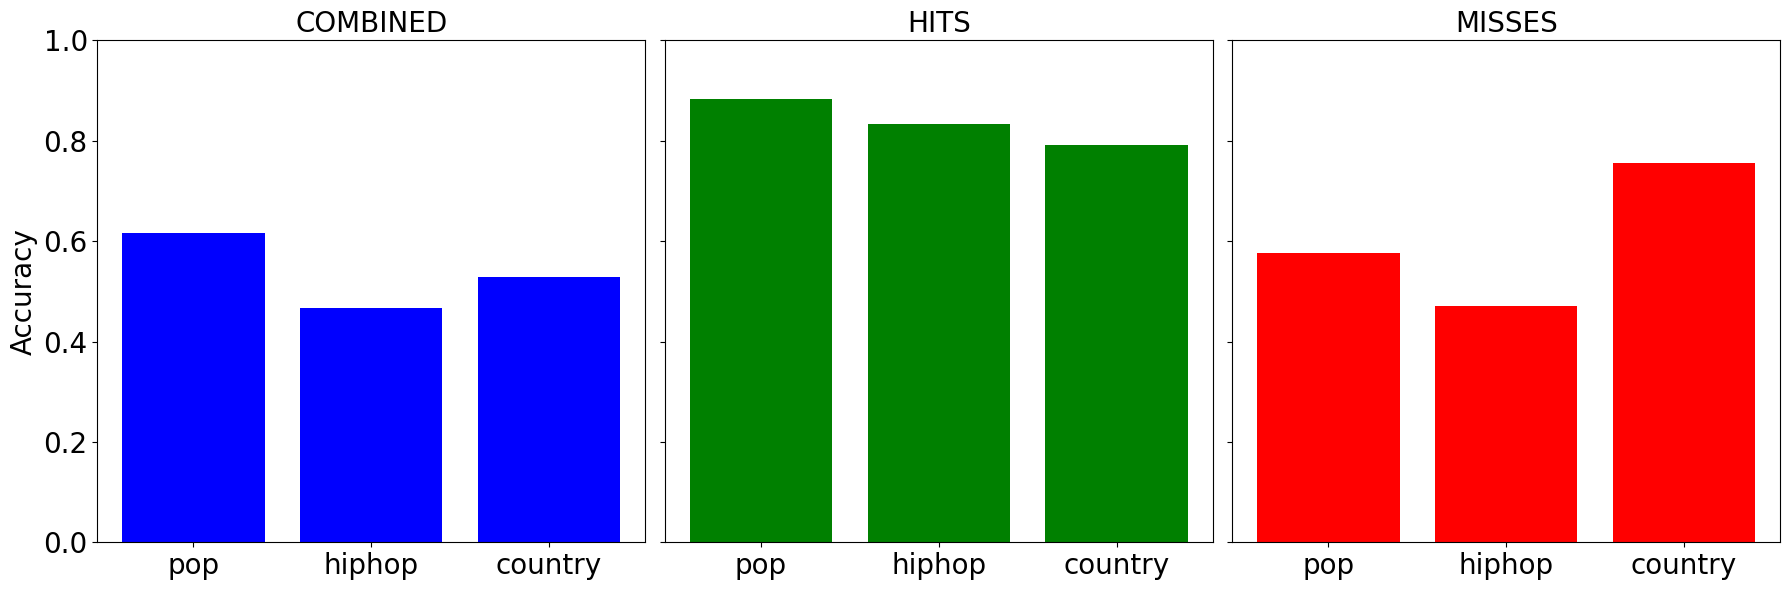

In [18]:
import matplotlib.pyplot as plt

# Filtered data for selected genres
selected_genres = ["pop", "hiphop", "country"]
filtered_combined_accs = [combined_genre_accs[genre] for genre in selected_genres]
filtered_bb_accs = [bb_genre_accs[genre] for genre in selected_genres]
filtered_rand_accs = [rand_genre_accs[genre] for genre in selected_genres]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax in axs:
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=0, labelsize=20)
    ax.tick_params(axis='y', labelsize=20)  # Set the fontsize for y-axis ticks here


# Combined
axs[0].bar(selected_genres, filtered_combined_accs, color='blue')
axs[0].set_title('COMBINED',fontsize=20)
axs[0].tick_params(axis='x', rotation=0, labelsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)

# Hits
axs[1].bar(selected_genres, filtered_bb_accs, color='green')
axs[1].set_title('HITS',fontsize=20)
axs[1].tick_params(axis='x', rotation=0, labelsize=20)

# Misses
axs[2].bar(selected_genres, filtered_rand_accs, color='red')
axs[2].set_title('MISSES', fontsize=20)
axs[2].tick_params(axis='x', rotation=0, labelsize=20)

plt.tight_layout()
plt.show()
